# Introduction

Notebook to aggregate the running of models in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Union Strategy

In [2]:
models_runner_1 = Feat_BR_Models_Runner()
lsi_model_1 = models_runner_1.run_lsi_model()
lda_model_1 = models_runner_1.run_lda_model()
bm25_model_1 = models_runner_1.run_bm25_model()
w2v_model_1 = models_runner_1.run_word2vec_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)
lsi_eval_1 = evaluator_1.run_evaluator(model=lsi_model_1)
lda_eval_1 = evaluator_1.run_evaluator(model=lda_model_1)
bm25_eval_1 = evaluator_1.run_evaluator(model=bm25_model_1)
w2v_eval_1 = evaluator_1.run_evaluator(model=w2v_model_1)

Features.shape: (21, 8)
SelectedBugReports.shape: (93, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix UNION.shape: (93, 21)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [3]:
evaluator_1.get_evaluations_df()

,model,ref_name,perc_precision,perc_recall,perc_fscore
0,lsi,top_1_cosine_0.0,43.01,31.23,34.49
1,lsi,top_3_cosine_0.0,26.52,52.76,33.36
2,lsi,top_5_cosine_0.0,18.28,58.63,26.44
3,lsi,top_10_cosine_0.0,11.40,71.04,18.78
4,lda,top_1_cosine_0.0,41.94,29.44,32.88
5,lda,top_3_cosine_0.0,20.43,41.08,25.60
6,lda,top_5_cosine_0.0,15.70,50.39,22.57
7,lda,top_10_cosine_0.0,11.40,69.54,18.73
8,bm25,top_1_cosine_0.0,36.56,25.80,28.68
9,bm25,top_3_cosine_0.0,24.01,48.42,30.42


### Plots

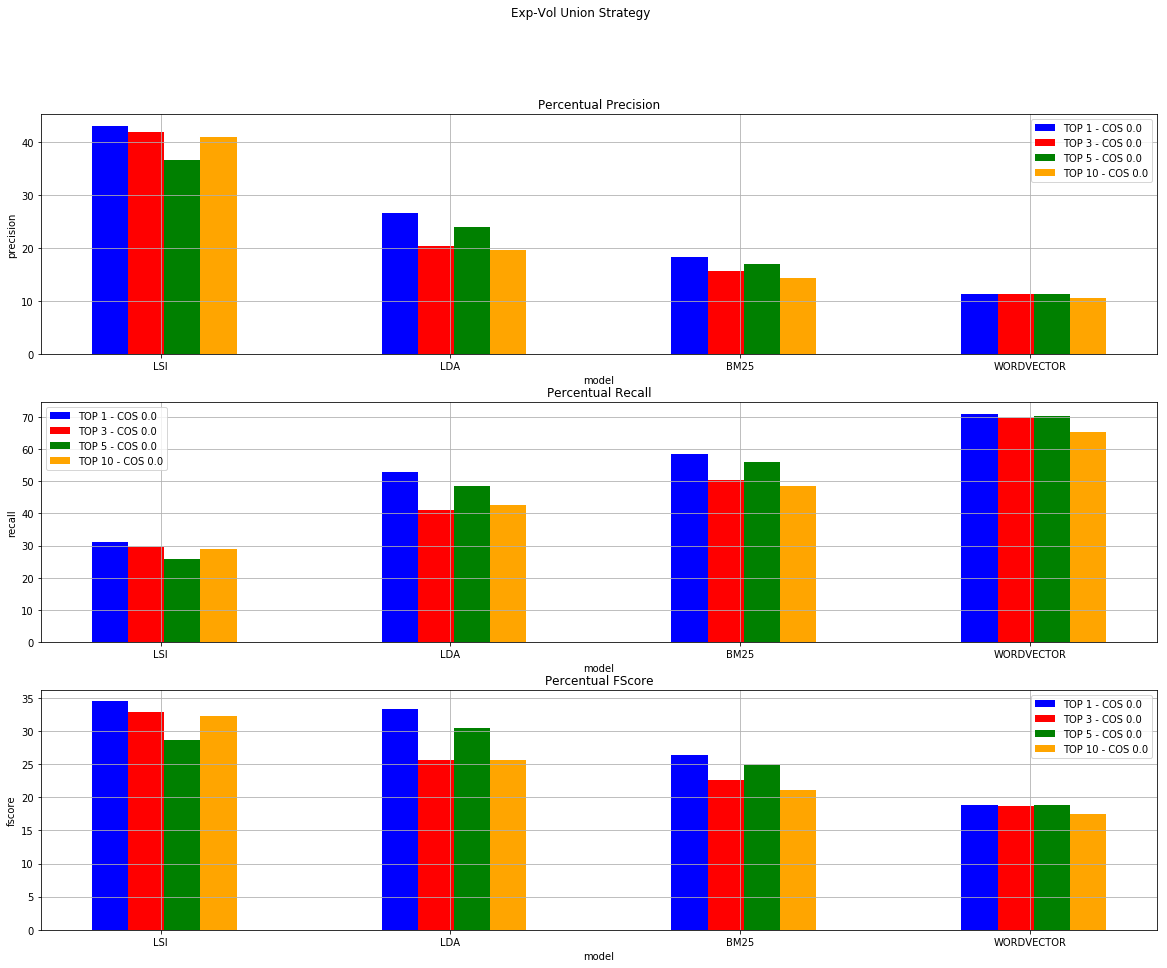

In [4]:
evaluator_1.plot_evaluations(title='Exp-Vol Union Strategy')

### Delete Variables

In [8]:
del lsi_model_1, lda_model_1, bm25_model_1, w2v_model_1
del lsi_eval_1, lda_eval_1, bm25_eval_1, w2v_eval_1
del models_runner_1, evaluator_1

## Intersec Strategy

In [9]:
models_runner_2 = Feat_BR_Models_Runner()
lsi_model_2 = models_runner_2.run_lsi_model()
lda_model_2 = models_runner_2.run_lda_model()
bm25_model_2 = models_runner_2.run_bm25_model()
w2v_model_2 = models_runner_2.run_word2vec_model()

evaluator_2 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_intersec_df().T)
lsi_eval_2 = evaluator_2.run_evaluator(model=lsi_model_2)
lda_eval_2 = evaluator_2.run_evaluator(model=lda_model_2)
bm25_eval_2 = evaluator_2.run_evaluator(model=bm25_model_2)
w2v_eval_2 = evaluator_2.run_evaluator(model=w2v_model_2)

Features.shape: (21, 8)
SelectedBugReports.shape: (93, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix INTERSEC.shape: (93, 21)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [10]:
evaluator_2.get_evaluations_df()

,model,ref_name,perc_precision,perc_recall,perc_fscore
0,lsi,top_1_cosine_0.0,26.88,26.34,26.52
1,lsi,top_3_cosine_0.0,13.26,38.71,19.68
2,lsi,top_5_cosine_0.0,7.96,38.71,13.16
3,lsi,top_10_cosine_0.0,3.98,38.71,7.20
4,lda,top_1_cosine_0.0,22.58,22.04,22.22
5,lda,top_3_cosine_0.0,8.60,24.73,12.69
6,lda,top_5_cosine_0.0,5.81,27.96,9.58
7,lda,top_10_cosine_0.0,3.66,35.48,6.61
8,bm25,top_1_cosine_0.0,19.35,18.82,19.00
9,bm25,top_3_cosine_0.0,11.11,32.80,16.56


### Plots

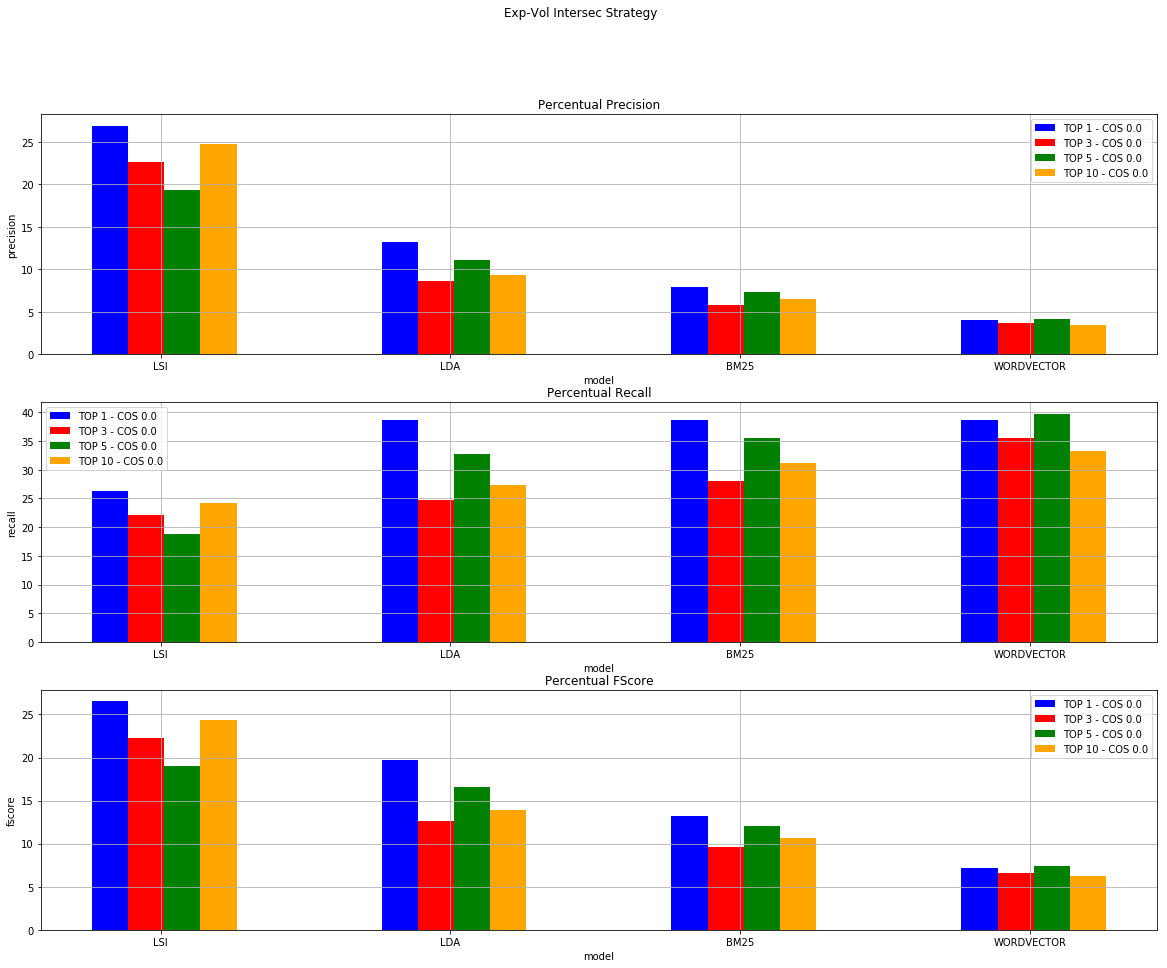

In [11]:
evaluator_2.plot_evaluations(title='Exp-Vol Intersec Strategy')

### Delete Variables

In [12]:
del lsi_model_2, lda_model_2, bm25_model_2, w2v_model_2
del lsi_eval_2, lda_eval_2, bm25_eval_2, w2v_eval_2
del models_runner_2, evaluator_2

## Expert Only Strategy

In [13]:
models_runner_3 = Feat_BR_Models_Runner()
lsi_model_3 = models_runner_3.run_lsi_model()
lda_model_3 = models_runner_3.run_lda_model()
bm25_model_3 = models_runner_3.run_bm25_model()
w2v_model_3 = models_runner_3.run_word2vec_model()

evaluator_3 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_df().T)
lsi_eval_3 = evaluator_3.run_evaluator(model=lsi_model_3)
lda_eval_3 = evaluator_3.run_evaluator(model=lda_model_3)
bm25_eval_3 = evaluator_3.run_evaluator(model=bm25_model_3)
w2v_eval_3 = evaluator_3.run_evaluator(model=w2v_model_3)

Features.shape: (21, 8)
SelectedBugReports.shape: (93, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Expert Matrix shape: (93, 21)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [14]:
evaluator_3.get_evaluations_df()

,model,ref_name,perc_precision,perc_recall,perc_fscore
0,lsi,top_1_cosine_0.0,40.86,37.99,38.89
1,lsi,top_3_cosine_0.0,20.79,55.02,29.64
2,lsi,top_5_cosine_0.0,12.90,55.91,20.62
3,lsi,top_10_cosine_0.0,6.67,58.06,11.84
4,lda,top_1_cosine_0.0,34.41,32.08,32.80
5,lda,top_3_cosine_0.0,13.62,36.38,19.50
6,lda,top_5_cosine_0.0,9.03,40.68,14.61
7,lda,top_10_cosine_0.0,5.81,51.25,10.33
8,bm25,top_1_cosine_0.0,30.11,27.78,28.49
9,bm25,top_3_cosine_0.0,17.56,47.49,25.23


### Plots

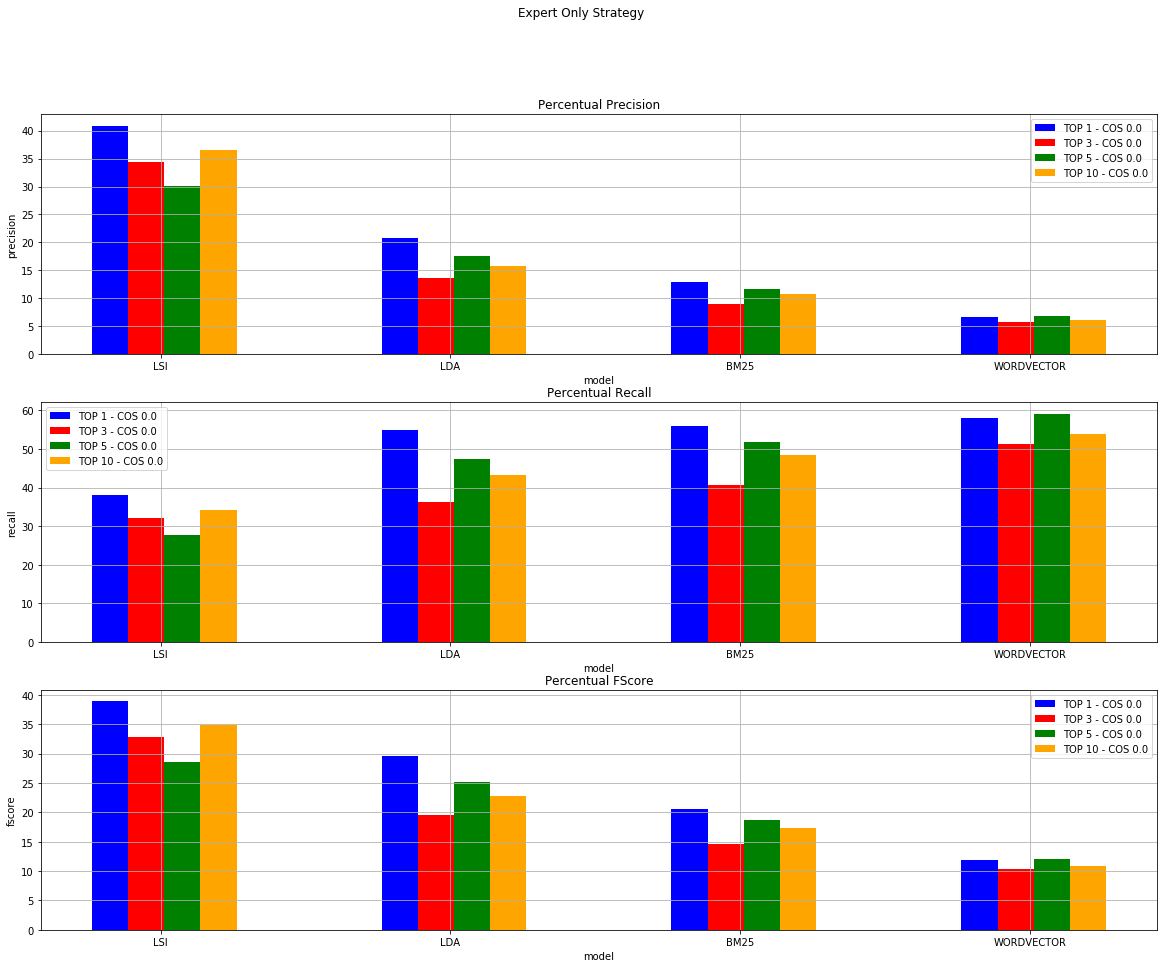

In [15]:
evaluator_3.plot_evaluations(title='Expert Only Strategy')

### Delete Variables

In [16]:
del lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3
del lsi_eval_3, lda_eval_3, bm25_eval_3, w2v_eval_3
del models_runner_3, evaluator_3

## Volunteers Only Strategy

In [17]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

evaluator_4 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T)
lsi_eval_4 = evaluator_4.run_evaluator(model=lsi_model_4)
lda_eval_4 = evaluator_4.run_evaluator(model=lda_model_4)
bm25_eval_4 = evaluator_4.run_evaluator(model=bm25_model_4)
w2v_eval_4 = evaluator_4.run_evaluator(model=w2v_model_4)

Features.shape: (21, 8)
SelectedBugReports.shape: (93, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (93, 21)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [18]:
evaluator_4.get_evaluations_df()

,model,ref_name,perc_precision,perc_recall,perc_fscore
0,lsi,top_1_cosine_0.0,29.03,24.33,25.46
1,lsi,top_3_cosine_0.0,19.00,45.32,25.35
2,lsi,top_5_cosine_0.0,13.33,51.91,20.09
3,lsi,top_10_cosine_0.0,8.71,63.15,14.56
4,lda,top_1_cosine_0.0,30.11,26.48,27.25
5,lda,top_3_cosine_0.0,15.41,37.40,20.60
6,lda,top_5_cosine_0.0,12.47,47.25,18.58
7,lda,top_10_cosine_0.0,9.25,66.94,15.48
8,bm25,top_1_cosine_0.0,25.81,21.32,22.23
9,bm25,top_3_cosine_0.0,17.56,43.14,23.80


### Plots

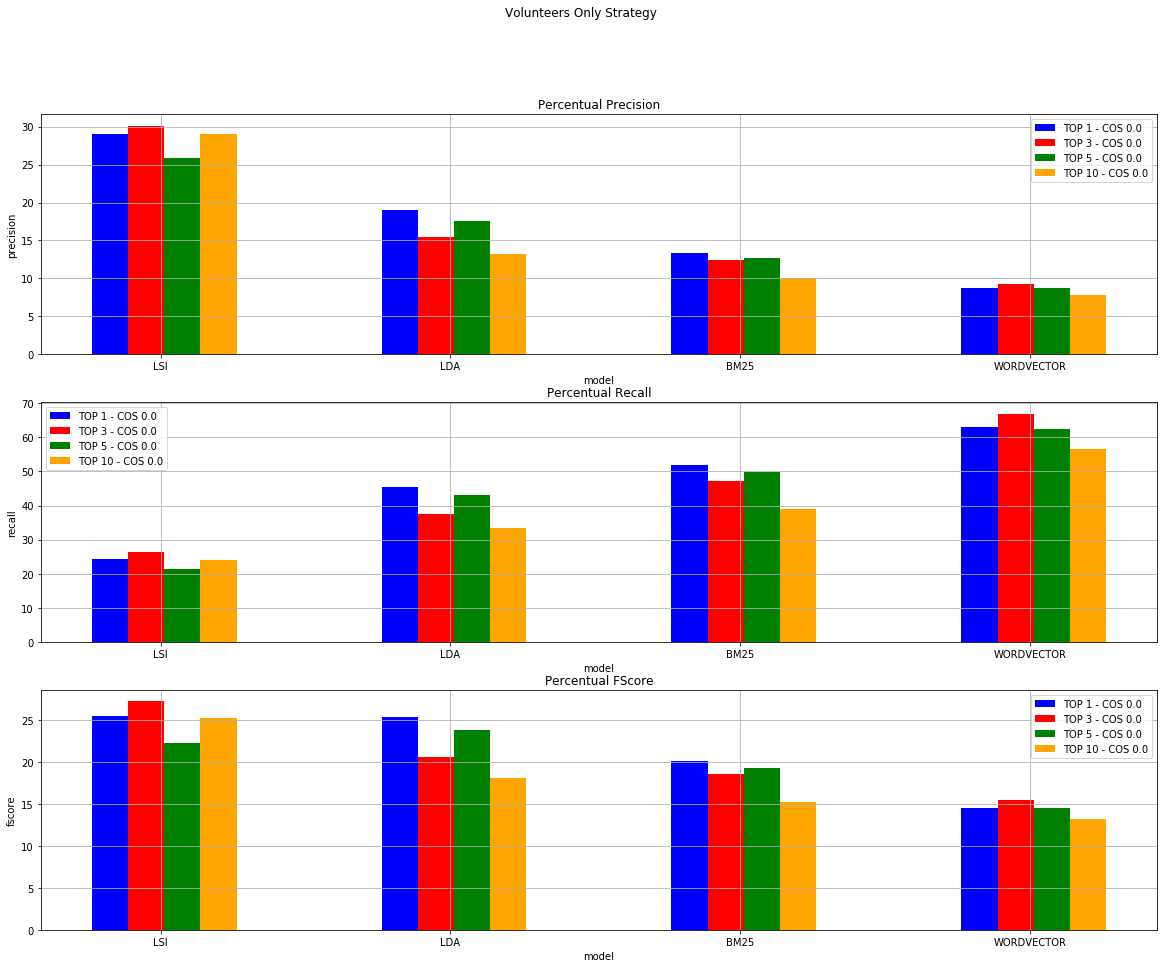

In [19]:
evaluator_4.plot_evaluations(title='Volunteers Only Strategy')

### Delete Variables

In [20]:
del lsi_model_4, lda_model_4, bm25_model_4, w2v_model_4
del lsi_eval_4, lda_eval_4, bm25_eval_4, w2v_eval_4
del models_runner_4, evaluator_4